In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import dataframe_image as dfi


In [2]:
bars_color = "gray"

In [3]:
def plot_figure(fig_width=2, fig_height=2):
    #define apeearance of figures

    COLOR = 'black'


    # Edit the font, font size, color and axes width

    plt.rcParams['font.size'] = 15
    plt.rcParams['axes.linewidth'] = 0.5

    tick_size=3
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['axes.edgecolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR


    # Create figure object and store it in a variable called 'fig'
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Add axes object to the figure that takes up entire figure
    ax = fig.add_axes([0, 0, 1, 1])


    # Edit the major and minor ticks of the x and y axes
    ax.xaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')

    return fig, ax




def get_readmittion_rates(data, column_name, min_size=0, min_size_wrong=0):
    df = data.copy()
    df.dropna(subset = [column_name], inplace=True)
    groups = df[column_name].unique()

    readmittion_rates = []
    groups_to_consider = []
    sample_size = []

    for group in groups:
        group_df = df[df[column_name]==group]
        if len(group_df) >= min_size:
            num_wrong_discharge = group_df.readmitted.sum()
            if num_wrong_discharge>=min_size_wrong:
                groups_to_consider.append(group)
                readmittion_rates.append(num_wrong_discharge/len(group_df))
                sample_size.append(len(group_df))


    
    return groups_to_consider, readmittion_rates, sample_size


def check_for_discrimination(data, column_name, subgroup = False, min_size=0, min_size_wrong=0):

    df = data.copy()
    df.readmitted = df.readmitted.replace(["Yes", "No"], [True, False])
    
    if subgroup:
        column_values = df[subgroup].unique()
        for column_value in column_values:
            df_subgroup = df[df[subgroup]==column_value]
            df_subgroup.dropna(subset = [subgroup], inplace=True)
            return get_readmittion_rates(df_subgroup, column_name, min_size, min_size_wrong)

    else: 
        return get_readmittion_rates(df, column_name, min_size, min_size_wrong)



In [4]:
data = pd.read_csv("data/cleaned_data.csv")
data

,admission_id,patient_id,race,gender,age,weight,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,...,blood_type,hemoglobin_level,blood_transfusion,max_glu_serum,A1Cresult,diuretics,insulin,change,diabetesMed,readmitted
0,0,199042938,Caucasian,Male,[50-60),NaN,3.0,1.0,1.0,1,...,A+,14.5,False,None,None,No,No,No,Yes,No
1,1,91962954,Caucasian,Male,[80-90),NaN,2.0,1.0,7.0,3,...,B+,15.7,False,None,>7,No,No,No,No,Yes
2,3,157495374,African American,Female,[70-80),NaN,NaN,1.0,NaN,2,...,AB-,13.5,False,None,>8,No,No,No,Yes,No
3,4,82692360,Caucasian,Female,NaN,NaN,1.0,22.0,7.0,12,...,A+,13.0,False,None,None,No,No,No,No,No
4,5,218016576,Caucasian,Female,[70-80),NaN,2.0,1.0,1.0,4,...,A+,13.1,False,None,None,No,No,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79189,81407,80746578,Caucasian,Male,[60-70),NaN,1.0,24.0,7.0,2,...,O+,15.4,False,None,None,No,Yes,Ch,Yes,No
79190,81408,221853996,African American,Female,[70-80),NaN,1.0,6.0,7.0,8,...,O+,12.8,False,None,None,No,Yes,Ch,Yes,No
79191,81409,104846580,African American,Female,[60-70),NaN,1.0,22.0,7.0,5,...,B+,13.0,False,None,None,No,No,No,No,Yes
79192,81410,229820346,Caucasian,Female,[50-60),NaN,3.0,1.0,2.0,1,...,AB+,13.3,True,None,None,No,No,No,Yes,No


In [7]:
df = pd.DataFrame(list(zip((data.isnull().sum()/len(data)*100).values, data.nunique().values, data.dtypes.values)),  
    columns=["% of missing values", "Number of unique values", "Data type"], index=data.columns)

dfi.export(df, "cleaned_data_overview.png")

[0204/170615.718934:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0204/170616.509046:INFO:headless_shell.cc(648)] Written to file /tmp/tmphivc7bgd/temp.png.
[0204/170617.295596:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0204/170618.373818:INFO:headless_shell.cc(648)] Written to file /tmp/tmpqp2siqan/temp.png.


In [8]:
all_features = ['race', 'gender', 'age', 'weight',
       'admission_type_code', 'discharge_disposition_code',
       'admission_source_code', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'has_prosthesis', 'complete_vaccination_status',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'blood_type',
       'hemoglobin_level', 'blood_transfusion', 'max_glu_serum', 'A1Cresult',
       'diuretics', 'insulin', 'change', 'diabetesMed']

#data = data[all_features]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


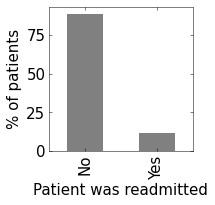

In [9]:
fig, ax = plot_figure()
(data.readmitted.value_counts()/len(data)*100).plot(kind="bar", color = bars_color)
ax.set_ylabel("% of patients")
ax.set_xlabel("Patient was readmitted")
title="Target_distribution"
fig.savefig(f'{title}_.png', dpi=300, transparent=True, bbox_inches='tight')

In [10]:
data.readmitted.value_counts()

No     70202
Yes     8992
Name: readmitted, dtype: int64

In [11]:
(data.readmitted.value_counts()/len(data))

No     0.886456
Yes    0.113544
Name: readmitted, dtype: float64

In [12]:
average_wrong_discharge_rate = (data.readmitted.value_counts()/len(data)).Yes

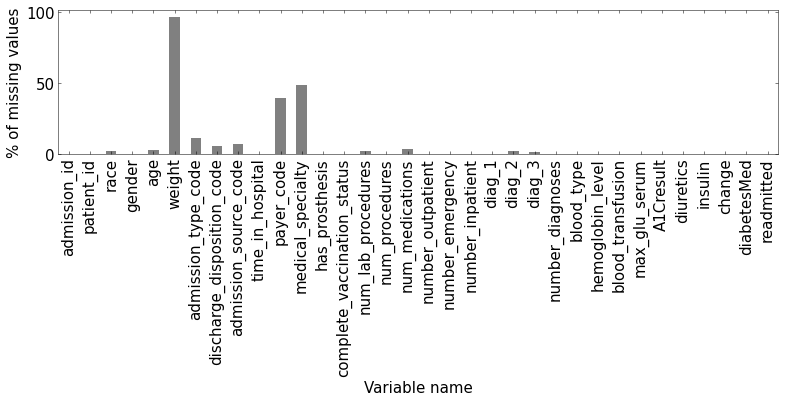

In [13]:
fig, ax = plot_figure(fig_width=10)
#data.gender.value_counts().plot(kind="bar", color = bars_color)
(data.isnull().sum()/len(data)*100).plot.bar(color = bars_color)
ax.set_ylabel("% of missing values")
ax.set_xlabel("Variable name")
title="Missing_values"
fig.savefig(f'{title}_.png', dpi=300, transparent=True, bbox_inches='tight')

In [21]:
def plot_wrongful_discharges(data, column_name, x_label = "", sub_group = False, min_size = 0, min_size_wrong = 0, fig_width=2):
    groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name, sub_group, min_size, min_size_wrong)
    fig, ax = plot_figure(fig_width)
    data_to_plot = pd.DataFrame(list(zip([r*100 for r in readmittion_rates], sample_size)), index = groups)
    if len(data_to_plot)>0:
        #Standard Error of the Proportion Formula:
        
        data_to_plot = data_to_plot.sort_index()
        sep = np.sqrt(data_to_plot[0].values*(100- data_to_plot[0].values)/(data_to_plot[1]))
        plt.axhline(average_wrong_discharge_rate*100, color = 'g', linestyle = '-', linewidth=4)
        plt.axhline(14, color = 'r', linestyle = '-', linewidth=4)
        ax.bar(data_to_plot[0].index, data_to_plot[0].values, yerr = sep, color = bars_color)
        plt.xticks(rotation=90)


        ax.set_ylabel("% of wrongful discharges")
        ax.set_xlabel(x_label)

        

 


    return fig, ax


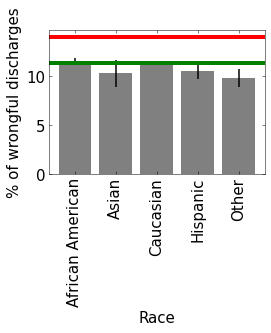

In [22]:
column_name = "race"
fig, ax = plot_wrongful_discharges(data, column_name, x_label="Race", min_size=0, min_size_wrong=0, fig_width=3)
fig.savefig(f'{column_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')


In [16]:

def get_difference_between_groups(groups, readmittion_rates):
    print(f"max difference: {(max(readmittion_rates) - min(readmittion_rates))*100}")
    print(f"Highest rate: {groups[np.where(readmittion_rates==max(readmittion_rates))[0][0]]}")
    print(f"Lowest rate: {groups[np.where(readmittion_rates==min(readmittion_rates))[0][0]]}")

In [17]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name)

get_difference_between_groups(groups, readmittion_rates)

max difference: 1.7021016401514488
Highest rate: African American
Lowest rate: Other


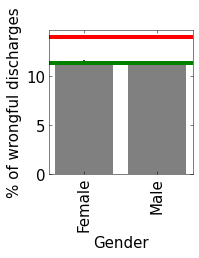

In [23]:
column_name = "gender"
fig, ax = plot_wrongful_discharges(data, column_name, x_label="Gender", min_size=0, min_size_wrong=0, fig_width=2)
fig.savefig(f'{column_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [24]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name)
get_difference_between_groups(groups, readmittion_rates)

max difference: 0.22488189733467778
Highest rate: Female
Lowest rate: Male


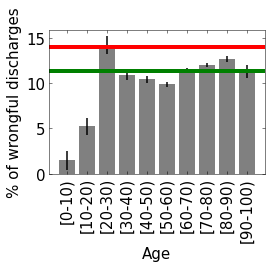

In [25]:
column_name = "age"

fig, ax = plot_wrongful_discharges(data, column_name, x_label="Age", min_size=0, min_size_wrong=0, fig_width=3)
fig.savefig(f'{column_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [26]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name)
get_difference_between_groups(groups, readmittion_rates)

max difference: 12.693576613018905
Highest rate: [20-30)
Lowest rate: [0-10)


In [20]:
readmittion_rates

[0.09841654670808395,
 0.1264088916718848,
 0.12007743644607469,
 0.11416490486257928,
 0.10396975425330812,
 0.10899182561307902,
 0.11289513296537883,
 0.14175058094500387,
 0.05223880597014925,
 0.014814814814814815]

In [21]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name, min_size_wrong=3)
get_difference_between_groups(groups, readmittion_rates)

max difference: 8.951177497485462
Highest rate: [20-30)
Lowest rate: [10-20)


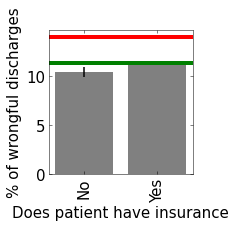

In [27]:
#is patient insured
payer_codes = list(data.payer_code.dropna().unique())
payer_codes.remove("SP")

data["isInsured"] = data.payer_code.replace(list(payer_codes), "Yes")
data["isInsured"] = data.isInsured.replace("SP", "No")
data["isInsured"].unique()

column_name = "isInsured"

fig, ax = plot_wrongful_discharges(data, column_name, x_label="Does patient have insurance", min_size=0, min_size_wrong=0, fig_width=2.)
fig.savefig(f'{column_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [28]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name)
get_difference_between_groups(groups, readmittion_rates)

max difference: 0.8547415357129801
Highest rate: Yes
Lowest rate: No


In [28]:
readmittion_rates

[0.11257597221587534, 0.10402855685874554]

In [29]:
len(data.medical_specialty.unique())

70

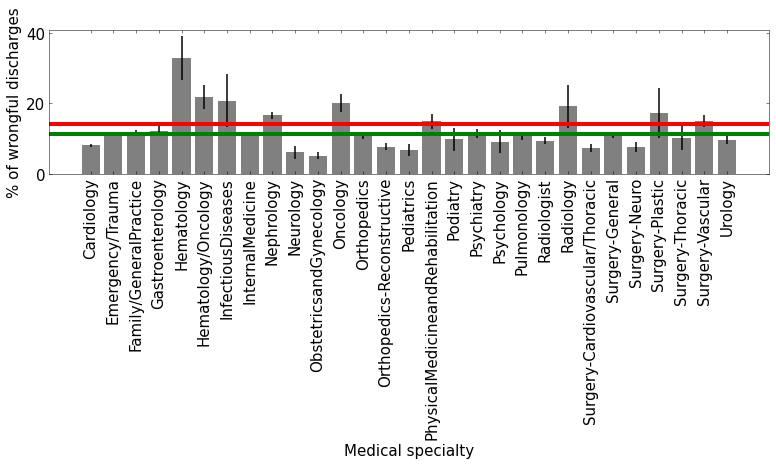

In [29]:
column_name = "medical_specialty"
fig, ax = plot_wrongful_discharges(data, column_name, x_label="Medical specialty", min_size=0, min_size_wrong=5, fig_width=10)
fig.savefig(f'{column_name}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [30]:
groups, readmittion_rates, sample_size = check_for_discrimination(data, column_name, min_size_wrong=5)

[(g, np.round(r*100, 2)) for g, r in zip(groups, readmittion_rates) if r>=0.14]

[('PhysicalMedicineandRehabilitation', 14.81),
 ('Surgery-Vascular', 14.92),
 ('Hematology/Oncology', 21.77),
 ('Nephrology', 16.55),
 ('Oncology', 20.0),
 ('Radiology', 19.05),
 ('Surgery-Plastic', 17.24),
 ('Hematology', 32.76),
 ('InfectiousDiseases', 20.69)]

In [31]:
get_difference_between_groups(groups, readmittion_rates)

max difference: 27.654650935401865
Highest rate: Hematology
Lowest rate: ObstetricsandGynecology


In [32]:
min(readmittion_rates)

0.05103969754253308

In [34]:
df = pd.DataFrame([(g, np.round(r*100, 2)) for g, r in zip(groups, readmittion_rates) if r-min(readmittion_rates)>0.05], columns=["Medical specialty", "% of readmissions"]).sort_values("% of readmissions", ascending=False).reset_index(drop=True)
dfi.export(df, "medical_specialties_worse_then_5.png")


[0204/171257.953197:ERROR:gpu_init.cc(441)] Passthrough is not supported, GL is swiftshader
[0204/171258.648292:INFO:headless_shell.cc(648)] Written to file /tmp/tmp9ce7fbon/temp.png.


In [35]:
groups

['Emergency/Trauma',
 'InternalMedicine',
 'Family/GeneralPractice',
 'Radiologist',
 'Cardiology',
 'PhysicalMedicineandRehabilitation',
 'Orthopedics-Reconstructive',
 'Psychiatry',
 'Surgery-Thoracic',
 'Surgery-Vascular',
 'Hematology/Oncology',
 'Orthopedics',
 'ObstetricsandGynecology',
 'Pediatrics',
 'Nephrology',
 'Urology',
 'Surgery-General',
 'Surgery-Cardiovascular/Thoracic',
 'Gastroenterology',
 'Pulmonology',
 'Oncology',
 'Podiatry',
 'Surgery-Neuro',
 'Neurology',
 'Radiology',
 'Surgery-Plastic',
 'Psychology',
 'Hematology',
 'InfectiousDiseases']

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/tmp/ipykernel_76642/4217335948.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(fig_width, fig_height))


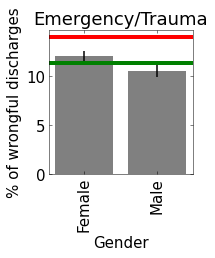

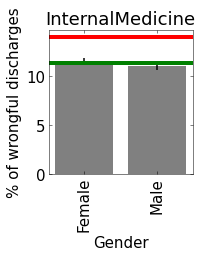

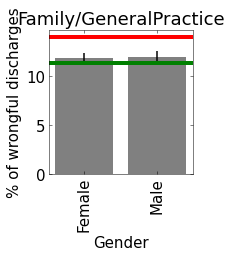

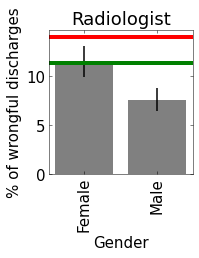

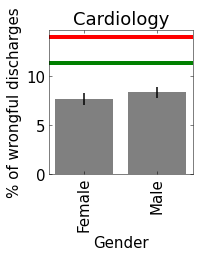

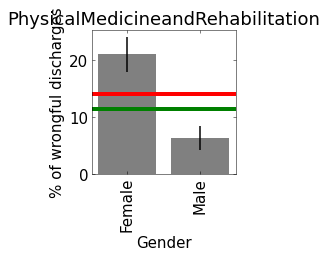

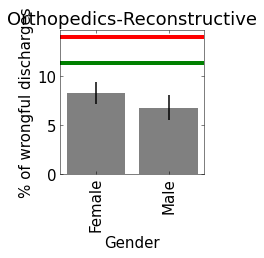

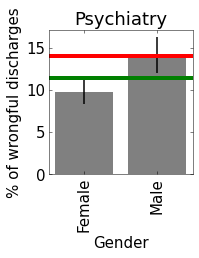

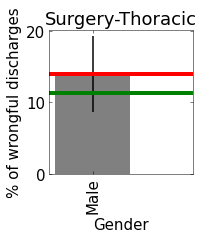

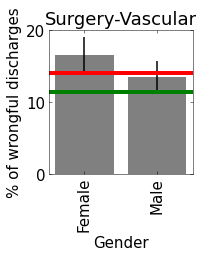

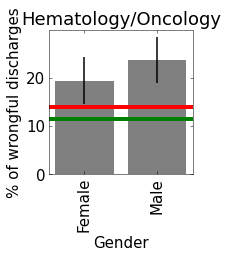

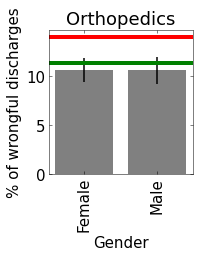

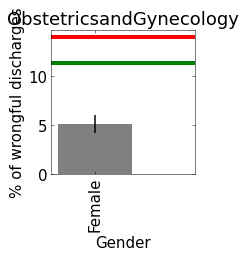

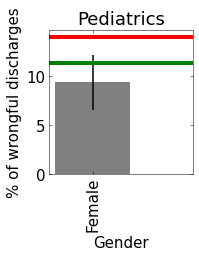

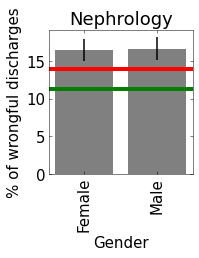

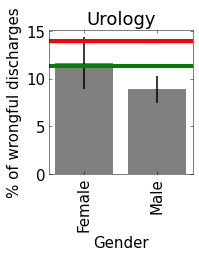

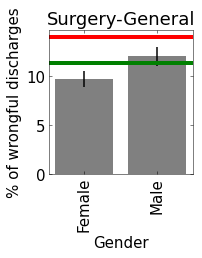

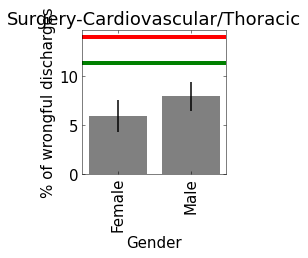

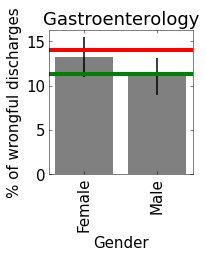

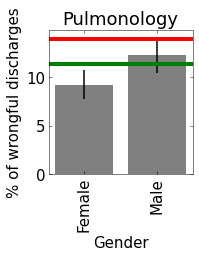

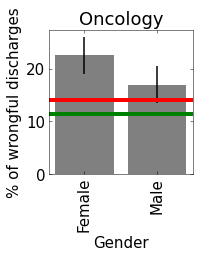

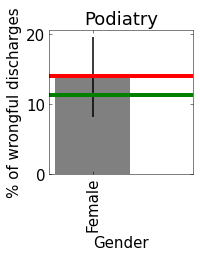

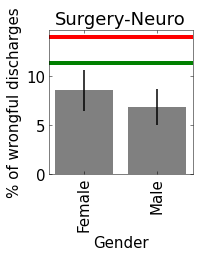

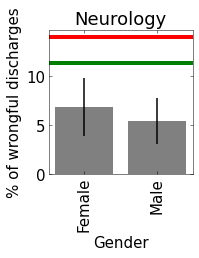

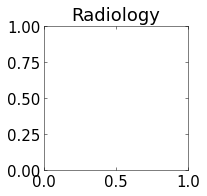

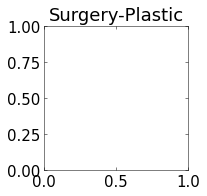

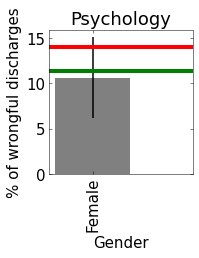

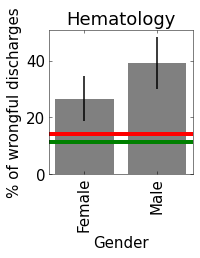

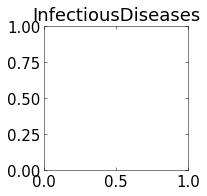

In [35]:
column_name = "gender"

for sub_group in groups:
    fig, ax = plot_wrongful_discharges(data[data.medical_specialty==sub_group], column_name, x_label="Gender", min_size=0, min_size_wrong=5, fig_width=2)
    plt.title(sub_group)
    fig.savefig(f'specialty_gender/{column_name}_{sub_group.replace("/", "")}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



/tmp/ipykernel_76642/4217335948.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(fig_width, fig_height))


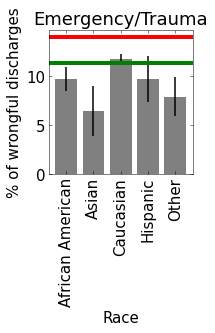

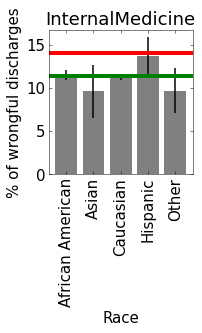

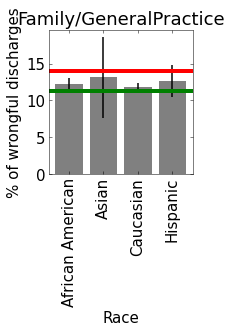

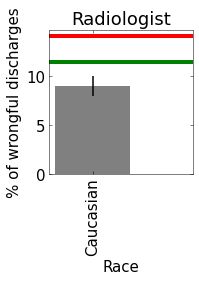

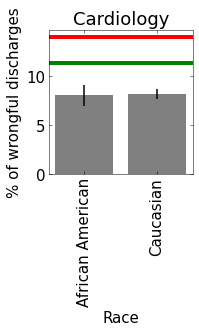

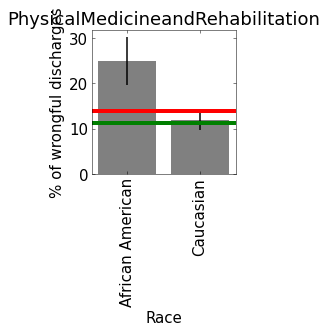

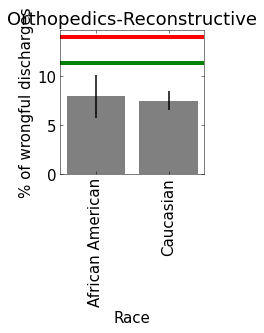

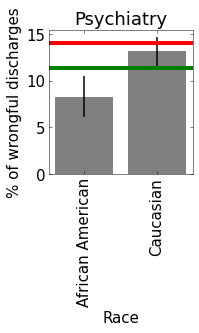

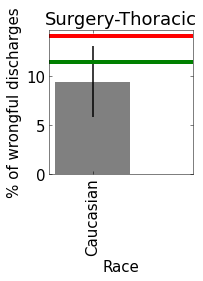

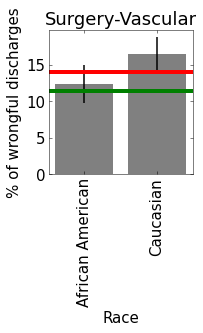

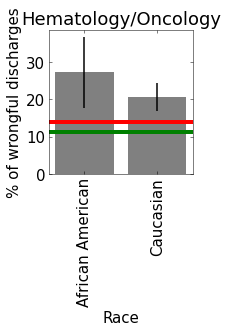

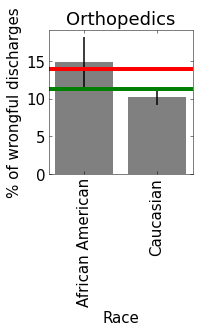

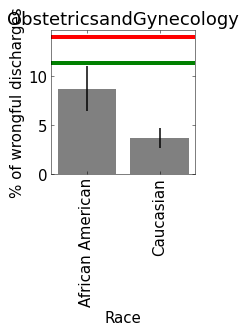

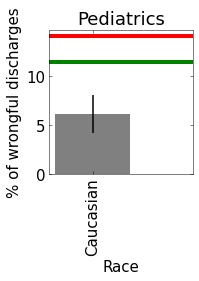

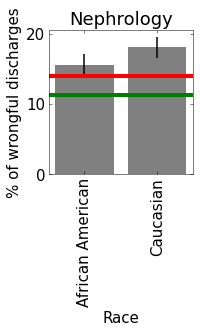

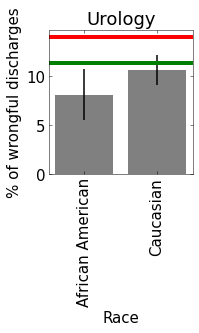

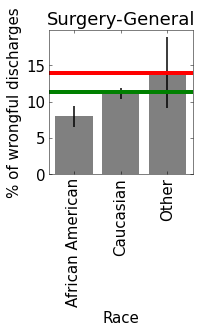

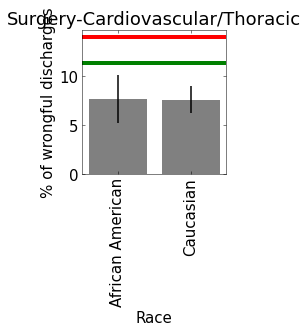

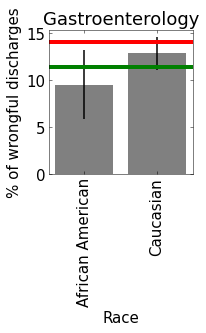

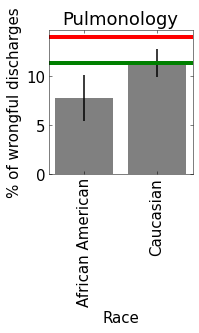

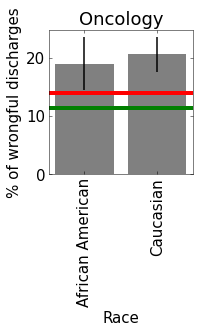

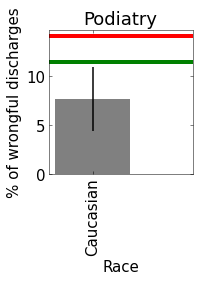

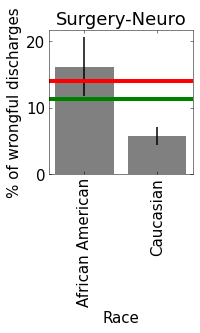

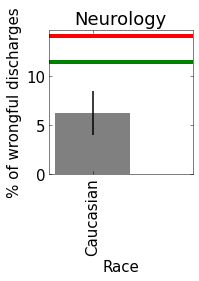

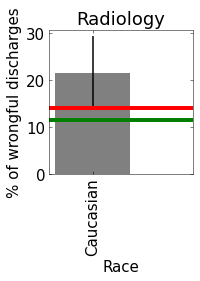

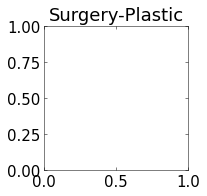

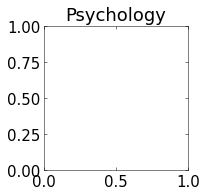

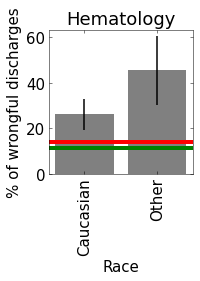

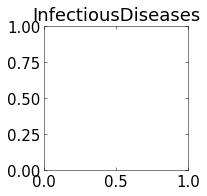

In [36]:
column_name = "race"

for sub_group in groups:
    fig, ax = plot_wrongful_discharges(data[data.medical_specialty==sub_group], column_name, x_label="Race", min_size=0, min_size_wrong=5, fig_width=2)
    plt.title(sub_group)
    fig.savefig(f'specialty_race/{column_name}_{sub_group.replace("/", "")}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



/tmp/ipykernel_76642/4217335948.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(fig_width, fig_height))


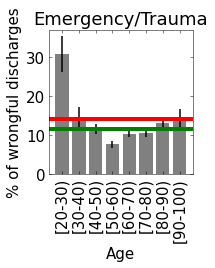

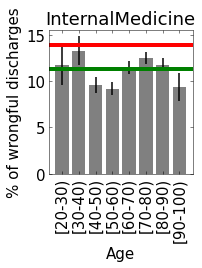

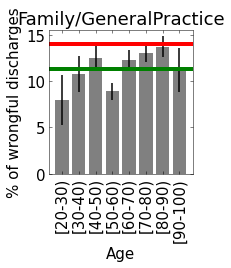

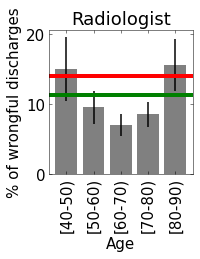

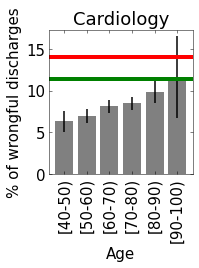

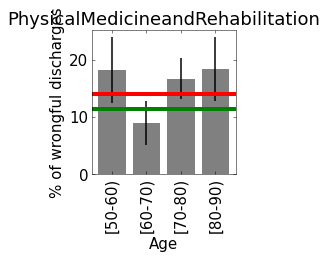

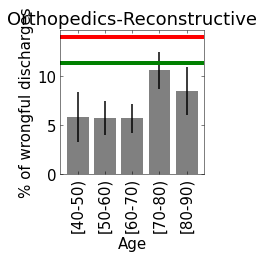

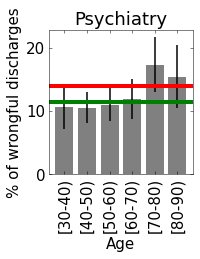

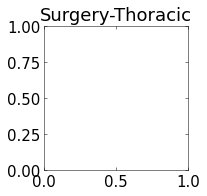

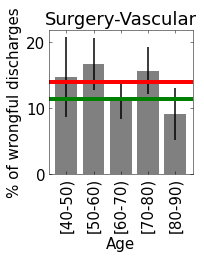

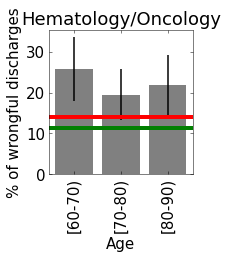

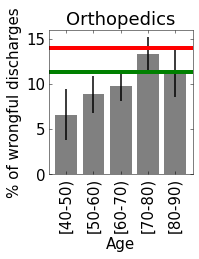

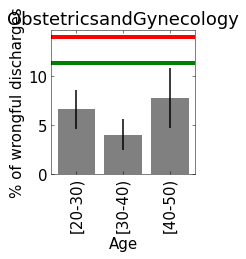

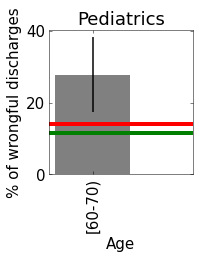

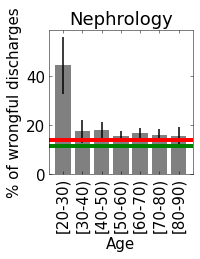

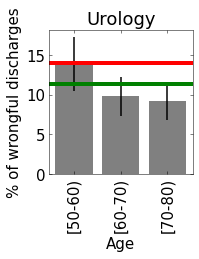

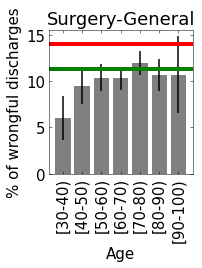

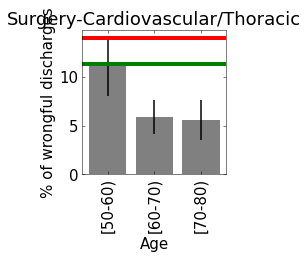

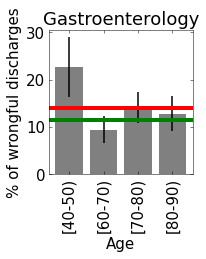

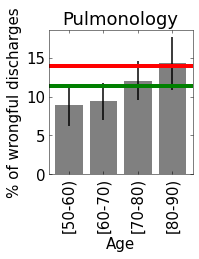

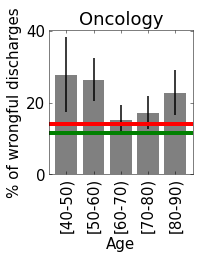

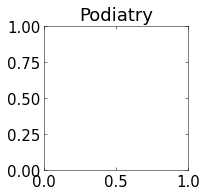

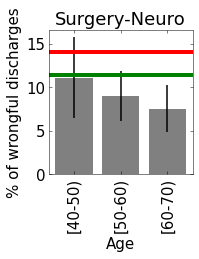

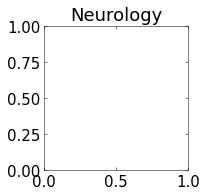

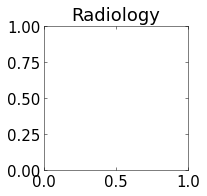

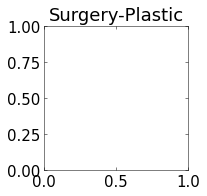

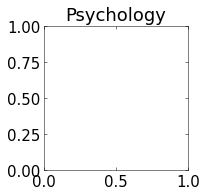

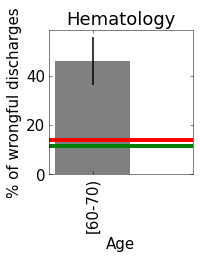

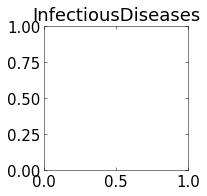

In [37]:
column_name = "age"

for sub_group in groups:
    fig, ax = plot_wrongful_discharges(data[data.medical_specialty==sub_group], column_name, x_label="Age", min_size=0, min_size_wrong=5, fig_width=2)
    plt.title(sub_group)
    fig.savefig(f'specialty_age/{column_name}_{sub_group.replace("/", "")}_wrongful_discharge.png', dpi=300, transparent=True, bbox_inches='tight')



In [39]:
data.corr()[data.corr().abs()>0.3]

,admission_id,patient_id,admission_type_code,discharge_disposition_code,admission_source_code,time_in_hospital,has_prosthesis,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,hemoglobin_level,blood_transfusion
admission_id,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
patient_id,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type_code,NaN,NaN,1.00000,NaN,-0.77979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discharge_disposition_code,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_source_code,NaN,NaN,-0.77979,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_in_hospital,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.316383,NaN,0.462031,NaN,NaN,NaN,NaN,NaN,NaN
has_prosthesis,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lab_procedures,NaN,NaN,NaN,NaN,NaN,0.316383,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_procedures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.382491,NaN,NaN,NaN,NaN,NaN,NaN
num_medications,NaN,NaN,NaN,NaN,NaN,0.462031,NaN,NaN,0.382491,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
